In [107]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import psutil
from tqdm import tqdm

from matplotlib_venn import venn2, venn3

In [2]:
# Print the memory use
psutil.virtual_memory().percent

63.4

### Pre-define optimal data types of the columns

In [3]:
%%time

# Read the train.csv dataset

# Define the data types
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16", 
    "content_type_id": "boolean", 
    "task_container_id": "int16",
    "user_answer": "int8", 
    "answered_correctly": "int8", 
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"    
}

# Import the records of all users
df_train = pd.read_csv("data_allusers/train.csv", dtype=dtypes)

# Print the memory use
print("Momoery usage after import train.csv: ", psutil.virtual_memory().percent)

# Read the example_test.csv dataset
df_test = pd.read_csv("data_allusers/example_test.csv", dtype=dtypes)

# Print the memory use
print("Momoery usage after import example_test.csv: ", psutil.virtual_memory().percent)

# Read the questions.csv
df_ques = pd.read_csv("data_allusers/questions.csv")

# Print the memory use
print("Momoery usage after import questions.csv: ", psutil.virtual_memory().percent)

# Read the lectures.csv
df_lecs = pd.read_csv("data_allusers/lectures.csv")

# Print the memory use
print("Momoery usage after import lectures.csv: ", psutil.virtual_memory().percent)

# Print the number of rows and columns in all datasets
df_train.shape, df_test.shape, df_ques.shape, df_lecs.shape

Momoery usage after import train.csv:  44.1
Momoery usage after import example_test.csv:  44.3
Momoery usage after import questions.csv:  41.9
Momoery usage after import lectures.csv:  41.9
CPU times: user 3min 41s, sys: 14.8 s, total: 3min 56s
Wall time: 4min


((101230332, 10), (104, 11), (13523, 5), (418, 4))

### Brief Summary of `train.csv`

In [4]:
# Print the first 5 rows in train.csv
df_train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


In [5]:
# Print the last 5 rows in train.csv
df_train.tail()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
101230327,101230327,428564420,2147482888,3586,False,22,0,1,18000.0,True
101230328,101230328,428585000,2147482888,6341,False,23,3,1,14000.0,True
101230329,101230329,428613475,2147482888,4212,False,24,3,1,14000.0,True
101230330,101230330,428649406,2147482888,6343,False,25,1,0,22000.0,True
101230331,101230331,428692118,2147482888,7995,False,26,3,1,29000.0,True


**Takeaways**
- **row_id**: ID for the row
- **timestamp**: the time between this user interaction and the first event from that user
- **content_id**: ID code for the user interaction: either answering a question or reviewing a lecture.
- **content_type_id**: 0 if the event was a question and 1 if the event was the user was watching a lecture. 
- **task_container_id**: ID code for the batch of questions or lectures.
- **user_answer**: the user's answer to the question. -1 if the user was watching a lecture.
- **answered_correctly**: if the user responded correctly. -1 if the user was watching a lecture.
- **prior_question_elapsed_time**: the avereage time it took a user to answer each question in the previous bundle, ignoring any lectures in between. 

In [6]:
# Count how many rows
df_train.row_id.nunique() # This number matches the first number in the shape.

101230332

In [7]:
# Count how many users
df_train.user_id.nunique() # There are about 390,000 users

393656

In [8]:
# Count how many unique contents
df_train.content_id.nunique() # There are 13782 unique contents

13782

In [9]:
# Count how many rows are questions and lectures
df_train.content_type_id.value_counts()

False    99271300
True      1959032
Name: content_type_id, dtype: Int64

In [10]:
# Count how many uniuqe tasks 
df_train.task_container_id.nunique()

10000

In [11]:
# Count
df_train.user_answer.value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

### Brief Summary of `questions.csv`

In [12]:
# Take a glance at the questions.csv
df_ques.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


**Takeaways**
- question_id: foreign key for the train/test contend_id column, when the content type is 0.
- bundle_id: code for which questions are served together.
- correct_answer: the answer to the question. Can be compared with the train `user_answer` column to check if the user was right.
- part: the relevant section of the TOEIC test.
- tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [18]:
# Print the shape of the df_ques 
df_ques.shape

(13523, 5)

In [13]:
# Count the number of unique questions
df_ques.question_id.nunique()

13523

In [14]:
# Count the number of unique bundles
df_ques.bundle_id.nunique()

9765

**Takeaways**
- There are 13523 unique questions.
- There are 9765 unique bundles.

### How is question related to bundle? 

In [145]:
# How many questions does each bundle id has? 

bundle_count = df_ques.groupby('bundle_id').size()
bundle_count = pd.DataFrame(bundle_id_count, columns=['questions_count'])

print("How many unique bundles in the dataset: ", bundle_count.shape[0])

#
bundle_count.head()

NameError: name 'bundle_id' is not defined

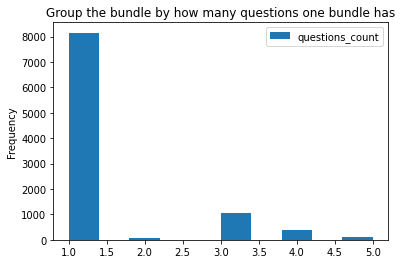

In [99]:
# Group the bundles by how many question each bundle has

bundle_id_count.plot(kind='hist')
plt.title("Group the bundle by how many questions one bundle has")
plt.show()

### How is the bundle related to part? 

In [144]:
# Count the 
df_ques.groupby('part').bundle_id.nunique()

part
1     992
2    1647
3     521
4     480
5    5511
6     304
7     310
Name: bundle_id, dtype: int64

**Takeaways**
- Different part contains different bundles.
- Part 5 contains the most bundles.

In [116]:
mask_part1 = (df_ques.part == 1)
mask_part2 = (df_ques.part == 2)
mask_part3 = (df_ques.part == 3)
mask_part4 = (df_ques.part == 4)
mask_part5 = (df_ques.part == 5)
mask_part6 = (df_ques.part == 6)
mask_part7 = (df_ques.part == 7)

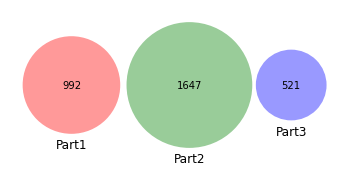

In [142]:
part1 = set(df_ques[mask_part1].bundle_id)
part2 = set(df_ques[mask_part2].bundle_id)
part3 = set(df_ques[mask_part3].bundle_id)
part4 = set(df_ques[mask_part4].bundle_id)
part5 = set(df_ques[mask_part5].bundle_id)
part6 = set(df_ques[mask_part6].bundle_id)
part7 = set(df_ques[mask_part7].bundle_id)

venn3([part1, part2, part3],
      ('Part1', 'Part2', 'Part3'))
plt.show()

In [139]:
a.shape, b.shape

((992,), (1647,))

In [40]:
# Merge the bundle_id_count with the df_ques

df_ques.merge(bundle_id_count, how='left', on='bundle_id')

,question_id,bundle_id,correct_answer,part,tags,questions_count
0,0,0,0,1,51 131 162 38,1
1,1,1,1,1,131 36 81,1
2,2,2,0,1,131 101 162 92,1
3,3,3,0,1,131 149 162 29,1
4,4,4,3,1,131 5 162 38,1
...,...,...,...,...,...,...
13518,13518,13518,3,5,14,1
13519,13519,13519,3,5,8,1
13520,13520,13520,2,5,73,1
13521,13521,13521,0,5,125,1


In [27]:
# Take bundle_id 8039 for example

mask8039 = (df_ques.bundle_id == 8039)
df_ques[mask8039]

,question_id,bundle_id,correct_answer,part,tags
8039,8039,8039,3,7,84 97 184 135
8040,8040,8039,2,7,84 39 184 135
8041,8041,8039,3,7,84 97 184 135
8042,8042,8039,0,7,84 97 184 135
8043,8043,8039,2,7,84 18 184 135


In [28]:
# Take bundle_id 8039 for example

mask8039 = (df_ques.bundle_id == 7431)
df_ques[mask8039]

,question_id,bundle_id,correct_answer,part,tags
7431,7431,7431,0,7,97 160 16 35 122 162
7432,7432,7431,2,7,39 160 16 35 122 162
7433,7433,7431,0,7,145 160 16 35 122 162
7434,7434,7431,0,7,76 160 16 35 122 162
7435,7435,7431,3,7,97 160 16 35 122 162


In [29]:
# Take bundle_id 8039 for example

mask8039 = (df_ques.bundle_id == 8029)
df_ques[mask8039]

,question_id,bundle_id,correct_answer,part,tags
8029,8029,8029,0,7,98 84 145 135
8030,8030,8029,0,7,98 84 39 135
8031,8031,8029,0,7,98 84 97 135
8032,8032,8029,3,7,98 84 118 135
8033,8033,8029,3,7,98 84 97 135


In [30]:
# Take bundle_id 8039 for example

mask8039 = (df_ques.bundle_id == 8024)
df_ques[mask8039]

,question_id,bundle_id,correct_answer,part,tags
8024,8024,8024,3,7,118 77 42 135 162
8025,8025,8024,1,7,118 77 42 135 162
8026,8026,8024,2,7,145 77 42 135 162
8027,8027,8024,0,7,145 77 42 135 162
8028,8028,8024,0,7,97 77 42 135 162


In [31]:
# Take bundle_id 8039 for example

mask8039 = (df_ques.bundle_id == 8019)
df_ques[mask8039]

,question_id,bundle_id,correct_answer,part,tags
8019,8019,8019,0,7,84 76 184 135
8020,8020,8019,3,7,84 97 184 135
8021,8021,8019,1,7,84 97 184 135
8022,8022,8019,2,7,84 18 184 135
8023,8023,8019,2,7,84 145 184 135


In [47]:
# Count the correct answers
df_ques.correct_answer.value_counts()

0    3716
3    3544
1    3478
2    2785
Name: correct_answer, dtype: int64

In [48]:
# Compute how many parts in the system and how many unique questions each part has
df_ques.part.value_counts()

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

#### Generate a column to hold the total number of tags for each question
- Hypothesis 1: the number of tags reflect how ??? the question is.
- Hypothesis 2: the more ??? the question, the lower accuracy is the question.

In [49]:
# Split the tag column into 
df_tags = df_ques.tags.str.split(" ", expand=True)

# Change the column names
df_tags.columns = [1,2,3,4,5,6]

# Fill the nulls with 0
df_tags = df_tags.fillna(-1)

# Print the dataframe of the tags
df_tags

,1,2,3,4,5,6
0,51,131,162,38,-1,-1
1,131,36,81,-1,-1,-1
2,131,101,162,92,-1,-1
3,131,149,162,29,-1,-1
4,131,5,162,38,-1,-1
...,...,...,...,...,...,...
13518,14,-1,-1,-1,-1,-1
13519,8,-1,-1,-1,-1,-1
13520,73,-1,-1,-1,-1,-1
13521,125,-1,-1,-1,-1,-1


In [50]:
# Convert the non-zero interger into 1 by a for loop

for i in range(1,7):
    n = df_tags[i].apply(lambda i: 1 if i !=-1 else 0)
    df_tags[i] = n
    
# Print the df_tags
df_tags

,1,2,3,4,5,6
0,1,1,1,1,0,0
1,1,1,1,0,0,0
2,1,1,1,1,0,0
3,1,1,1,1,0,0
4,1,1,1,1,0,0
...,...,...,...,...,...,...
13518,1,0,0,0,0,0
13519,1,0,0,0,0,0
13520,1,0,0,0,0,0
13521,1,0,0,0,0,0


In [51]:
# Create a column to hold the total count of the tag numbers for each question
df_tags['tag_count'] = df_tags.sum(axis=1)

# Drop the columns 1-6
df_tags.drop(columns=[1,2,3,4,5,6], inplace=True)

# Print the df_tags
df_tags

,tag_count
0,4
1,3
2,4
3,4
4,4
...,...
13518,1
13519,1
13520,1
13521,1


In [52]:
# Attach the column of counting tags to the quetions.csv
df_ques = pd.concat([df_ques, df_tags], axis=1)

# Print the first 5 rows in the df_ques
df_ques.head()

,question_id,bundle_id,correct_answer,part,tags,tag_count
0,0,0,0,1,51 131 162 38,4
1,1,1,1,1,131 36 81,3
2,2,2,0,1,131 101 162 92,4
3,3,3,0,1,131 149 162 29,4
4,4,4,3,1,131 5 162 38,4


In [53]:
# # Save it to the csv
# df_ques.to_csv("questions.csv")

In [54]:
# Count the number of unique questions based on tag_count
df_ques.tag_count.value_counts()

1    6560
3    3976
4    2021
5     686
2     171
6     108
0       1
Name: tag_count, dtype: int64

### Brief Summary of `lectures.csv`

In [41]:
# Print the first 5 records
df_lecs.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [42]:
# Count how many unique lectures
df_lecs.lecture_id.nunique() # There are 418 unique lectures

418

In [43]:
# Coun how many unique tags
df_lecs.tag.nunique() # There are 151 unique tag numbers

151

In [44]:
# Count how many unique lectures in each type
df_lecs.type_of.value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [45]:
# Count how many unique lectures in ech part
df_lecs.part.value_counts()

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [46]:
# Add an extra column to hold the name of the parts.

map_dict = {1: "Photographs", 
            2: "Question-Response", 
            3: "Conversations", 
            4: "Talks", 
            5: "Incomplete Sentences", 
            6: "Text Completion", 
            7: "Passages"}

df_lecs['part_content'] = df_lecs.part.map(map_dict)

# Check if the column is successfully created
df_lecs.head()

,lecture_id,tag,part,type_of,part_content
0,89,159,5,concept,Incomplete Sentences
1,100,70,1,concept,Photographs
2,185,45,6,concept,Text Completion
3,192,79,5,solving question,Incomplete Sentences
4,317,156,5,solving question,Incomplete Sentences


In [92]:
df_lecs.groupby('part').lecture_id.count()

part
1     54
2     56
3     19
4     31
5    143
6     83
7     32
Name: lecture_id, dtype: int64

In [74]:
# # Save as csv file
# df_lecs.to_csv("lectures.csv")

### Merge questions.csv and lecture.csv through content_id

In [63]:
content_id = df_train[['content_id', 'task_container_id']]
content_id.shape

(101230332, 2)

In [65]:
content_id = content_id.merge(df_ques, how='left', left_on='content_id', right_on='question_id')
content_id

,content_id,task_container_id,question_id,bundle_id,correct_answer,part,tags,tag_count
0,5692,1,5692.0,5692.0,3.0,5.0,151,1.0
1,5716,2,5716.0,5716.0,2.0,5.0,168,1.0
2,128,0,128.0,128.0,0.0,1.0,131 149 92,3.0
3,7860,3,7860.0,7860.0,0.0,1.0,131 104 81,3.0
4,7922,4,7922.0,7922.0,1.0,1.0,131 149 92,3.0
...,...,...,...,...,...,...,...,...
101230327,3586,22,3586.0,3586.0,0.0,5.0,8,1.0
101230328,6341,23,6341.0,6341.0,3.0,5.0,60,1.0
101230329,4212,24,4212.0,4212.0,3.0,5.0,95,1.0
101230330,6343,25,6343.0,6343.0,0.0,5.0,60,1.0


In [66]:
df = content_id.merge(df_lecs, how='left', left_on='content_id', right_on='lecture_id')
df

,content_id,task_container_id,question_id,bundle_id,correct_answer,part_x,tags,tag_count,lecture_id,tag,part_y,type_of,part_content
0,5692,1,5692.0,5692.0,3.0,5.0,151,1.0,NaN,NaN,NaN,NaN,NaN
1,5716,2,5716.0,5716.0,2.0,5.0,168,1.0,NaN,NaN,NaN,NaN,NaN
2,128,0,128.0,128.0,0.0,1.0,131 149 92,3.0,NaN,NaN,NaN,NaN,NaN
3,7860,3,7860.0,7860.0,0.0,1.0,131 104 81,3.0,NaN,NaN,NaN,NaN,NaN
4,7922,4,7922.0,7922.0,1.0,1.0,131 149 92,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101230327,3586,22,3586.0,3586.0,0.0,5.0,8,1.0,NaN,NaN,NaN,NaN,NaN
101230328,6341,23,6341.0,6341.0,3.0,5.0,60,1.0,NaN,NaN,NaN,NaN,NaN
101230329,4212,24,4212.0,4212.0,3.0,5.0,95,1.0,NaN,NaN,NaN,NaN,NaN
101230330,6343,25,6343.0,6343.0,0.0,5.0,60,1.0,NaN,NaN,NaN,NaN,NaN


In [94]:
# How many task container id in each part? 
content_id.groupby('part').task_container_id.nunique()

part
1.0    10000
2.0    10000
3.0    10000
4.0    10000
5.0    10000
6.0     9999
7.0     9954
Name: task_container_id, dtype: int64

In [68]:
# How many unique task_container_id in total? 
df.task_container_id.nunique()

10000

**Takeaways**
- There are 10000 unique task in the dataset. 
- Each part contains almost/all the task. 

In [69]:
# How many unique lectures
df.lecture_id.nunique() # 

417

In [87]:
# Does the task_container_id contain lecture id? 

mask = (df.task_container_id == 2)
task1 = df[mask]
task1

,content_id,task_container_id,question_id,bundle_id,correct_answer,part_x,tags,tag_count,lecture_id,tag,part_y,type_of,part_content
1,5716,2,5716.0,5716.0,2.0,5.0,168,1.0,NaN,NaN,NaN,NaN,NaN
48,175,2,175.0,175.0,2.0,1.0,9 10 92,3.0,NaN,NaN,NaN,NaN,NaN
78,5976,2,5976.0,5976.0,2.0,5.0,152,1.0,NaN,NaN,NaN,NaN,NaN
98,217,2,217.0,217.0,0.0,2.0,143 71 29 102,4.0,NaN,NaN,NaN,NaN,NaN
226,6456,2,6456.0,6456.0,2.0,5.0,48,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101228991,175,2,175.0,175.0,2.0,1.0,9 10 92,3.0,NaN,NaN,NaN,NaN,NaN
101229219,175,2,175.0,175.0,2.0,1.0,9 10 92,3.0,NaN,NaN,NaN,NaN,NaN
101229977,9261,2,9261.0,9261.0,0.0,5.0,173,1.0,NaN,NaN,NaN,NaN,NaN
101230027,5474,2,5474.0,5474.0,1.0,5.0,91,1.0,NaN,NaN,NaN,NaN,NaN


In [88]:
task1.bundle_id.nunique()

4187

In [89]:
task1.lecture_id.value_counts().size

81

In [ ]:
df.groupby('tags')

### Brief Summary of `example_test.csv`

In [75]:
# Take a peek at the test
df_test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,False,0,NaN,<NA>,[],[]
1,1,0,13309898705,554169193,12010,False,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,False,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,False,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,False,162,72400.0,True,NaN,NaN


**Takeawasys**
- Extra columns comparing to the train.csv:

### Subtract the History of Users in the Test Dataset

In [10]:
# Subtract user ids in the example test dataset
user_ids_test = df_test['user_id'].unique()

# Convert to the list
user_ids_test = list(user_ids_test)

# Print how many users in the example test dataset
print(f"There are {len(user_ids_test)} users in the example test dataset")

# Print the user ids
print(user_ids_test)

There are 42 users in the example test dataset
[275030867, 554169193, 1720860329, 288641214, 1728340777, 1364159702, 1521618396, 1317245193, 1700555100, 998511398, 1422853669, 1096784725, 385471210, 1202386221, 2018567473, 1233875513, 891955351, 1981166446, 1637273633, 2030979309, 319060572, 98059812, 674533997, 555691277, 775113212, 1219481379, 1148874033, 1281335472, 2002570769, 706626847, 1357500007, 1599808246, 1305988022, 1310228392, 2093197291, 1468996389, 1838324752, 2103436554, 311890082, 1817433235, 1900527744, 7792299]


In [15]:
%%time
# Compute how long my laptop will complete the task

# Subtract the history of the users in the example test dataset

# Create an empty dataframe
df = pd.DataFrame(columns=df_train.columns)

for user_id in tqdm(user_ids_test):
    if (df_train.user_id == user_id).sum() > 0: 
        mask = df_train.user_id == user_id
        user = df_train[mask]
        df = df.append(user, ignore_index=True)
    else:
        continue

# Print the shape of the df
print(df.shape)

# Print the first 5 rows in df
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:14<00:00,  2.86it/s]

(72719, 10)
Wall time: 14.7 s


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,25924315,0,554169193,3927,False,0,1,1,NaN,<NA>
1,25924316,24904,554169193,939,False,1,0,1,23000.0,False
2,25924317,59273,554169193,6683,False,2,1,0,19000.0,False
3,25924318,95917,554169193,5658,False,3,3,1,30000.0,False
4,25924319,112132,554169193,6202,False,4,2,1,31000.0,False


In [72]:
# # Save df as csv
# df.to_csv("users_history_test.csv")

### The Detaisl of Time-series API 
- The API provides user interactions groups in the order in which they occurred. Each group will contain interactions from many different users, but no more than one `task_container_id` of questions from any single user. Each group has between 1 and 1000 users.
- Expected to see roughly 2.5 million questions in the hidden test set. 